# Preproceeseing

In [1]:
from nba_api.stats.endpoints import PlayerGameLogs, LeagueStandingsV3
from nba_api.stats.static import players, teams

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

In [2]:
def make_last (df):
    string_columns = df.select_dtypes(include='object').columns.tolist()
    non_string_columns = df.select_dtypes(exclude='object').columns.tolist()
    ordered_columns = non_string_columns + string_columns
    df = df[ordered_columns]
    return df


def add_target(group):
    group["target"] = group["won"].shift(-1)
    group["target"].fillna(2, inplace=True)
    return group


def check_data_quality(df):
    print("The shape:")
    print(df.shape)

    
    missing_values = df.isna().sum()
    if missing_values.sum() == 0:
        print("\nNo missing values found.")
    else:
        print("Columns with missing values:")
        print(missing_values[missing_values != 0])

    print("\nData types:")
    print(df.dtypes)
    
    print("\nUnique types:")
    print(df.nunique())

    print("\nSummary Statistics:")
    df.describe()

    df.hist(bins=50, figsize=(20,15))

The shape:
(175727, 68)

No missing values found.

Data types:
SEASON_YEAR              object
PLAYER_ID                 int64
PLAYER_NAME              object
NICKNAME                 object
TEAM_ID                   int64
                          ...  
NBA_FANTASY_PTS_RANK      int64
DD2_RANK                  int64
TD3_RANK                  int64
WNBA_FANTASY_PTS_RANK     int64
VIDEO_AVAILABLE_FLAG      int64
Length: 68, dtype: object

Unique types:
SEASON_YEAR                 7
PLAYER_ID                1169
PLAYER_NAME              1169
NICKNAME                  721
TEAM_ID                    30
                         ... 
NBA_FANTASY_PTS_RANK     3938
DD2_RANK                    8
TD3_RANK                    8
WNBA_FANTASY_PTS_RANK     512
VIDEO_AVAILABLE_FLAG        3
Length: 68, dtype: int64

Summary Statistics:


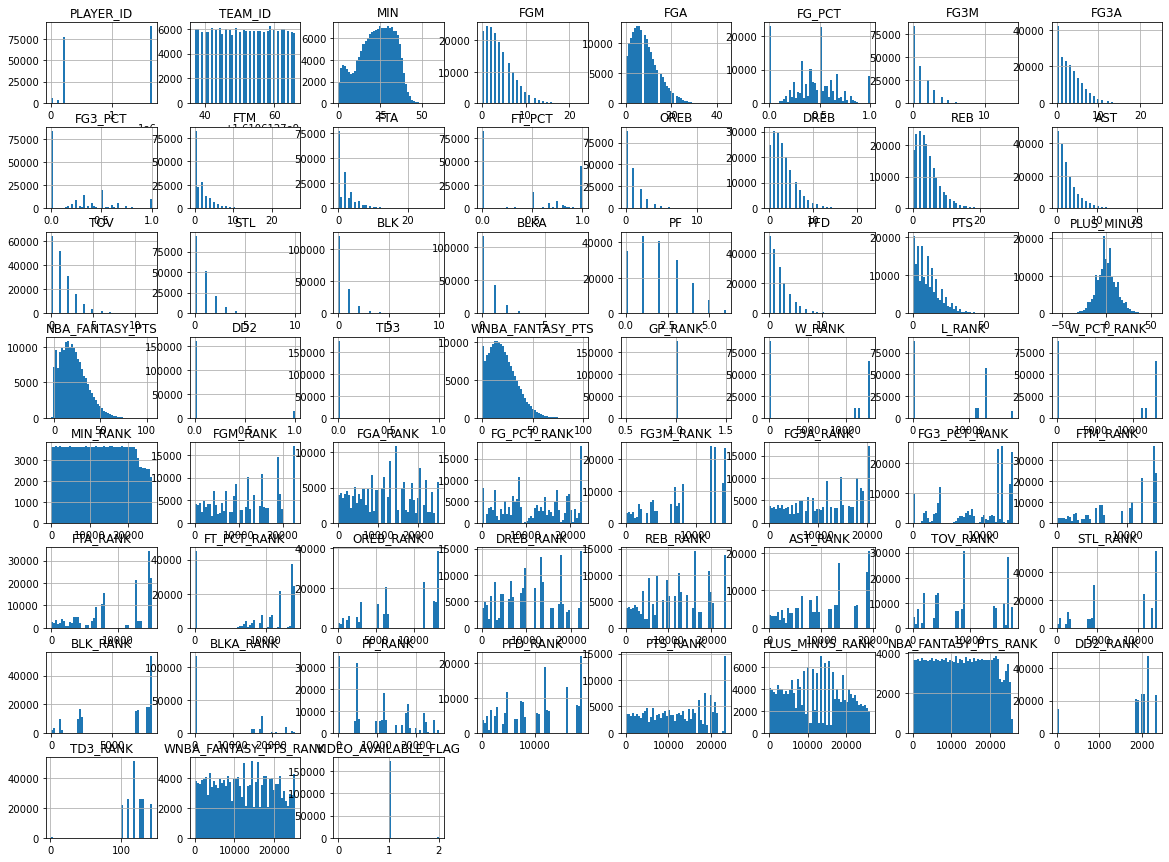

In [3]:
def mergeDbStats(year, df):
    df_stats_new = PlayerGameLogs(season_nullable=year).get_data_frames()[0]
    df = pd.concat([df_stats_new, df], ignore_index=True)
    return df

    
    
    
df_stats_all_years = PlayerGameLogs(season_nullable='2016-17').get_data_frames()[0]
df_stats_all_years = mergeDbStats('2017-18', df_stats_all_years)
df_stats_all_years = mergeDbStats('2018-19', df_stats_all_years)
df_stats_all_years = mergeDbStats('2019-20', df_stats_all_years)
df_stats_all_years = mergeDbStats('2020-21', df_stats_all_years)
df_stats_all_years = mergeDbStats('2021-22', df_stats_all_years)
df_stats_all_years = mergeDbStats('2022-23', df_stats_all_years)

check_data_quality(df_stats_all_years) 

In [4]:
df_player_preprocess = df_stats_all_years

In [5]:
df_player_preprocess["VIDEO_AVAILABLE_FLAG"] = df_player_preprocess['MATCHUP'].str.split(' ', n = 2, expand = True)[2]
df_player_preprocess.rename(columns={"VIDEO_AVAILABLE_FLAG": "team_opp"}, inplace=True)

del df_player_preprocess["MATCHUP"]


df_player_preprocess["GAME_DATE"] = df_player_preprocess['GAME_DATE'].str.split('T', n = 2, expand = True)[0]


WL = df_player_preprocess['WL']
del df_player_preprocess["WL"]
WL = WL.map({'W': 1, 'L': 0, np.nan: 2})
df_player_preprocess["won"] = WL


df_player_preprocess = df_player_preprocess.sort_values("GAME_DATE")


df_player_preprocess = df_player_preprocess.groupby("PLAYER_ID", group_keys=False).apply(add_target)


del df_player_preprocess['PLAYER_ID']
del df_player_preprocess['NICKNAME']
del df_player_preprocess['TEAM_NAME']
del df_player_preprocess['TEAM_ID']
del df_player_preprocess['GAME_ID']


df_player_preprocess = df_player_preprocess.rename(columns={'TEAM_ABBREVIATION': 'team'})
df_player_preprocess = df_player_preprocess.rename(columns={'PLAYER_NAME': 'player'})
df_player_preprocess = df_player_preprocess.rename(columns={'SEASON_YEAR': 'season'})


df_player_preprocess = make_last(df_player_preprocess)


print('WON columns value counts:')
print(df_player_preprocess["won"].value_counts())
print('\nTARGET column value counts:')
print(df_player_preprocess["target"].value_counts())

WON columns value counts:
1    88060
0    87667
Name: won, dtype: int64

TARGET column value counts:
1.0    87529
0.0    87029
2.0     1169
Name: target, dtype: int64


The shape:
(17772, 150)
Columns with missing values:
+/-             17772
mp_max          17772
mp_max.1        17772
+/-_opp         17772
mp_max_opp      17772
mp_max_opp.1    17772
dtype: int64

Data types:
mp           float64
mp.1         float64
fg           float64
fga          float64
fg%          float64
              ...   
total_opp      int64
home_opp       int64
season         int64
date          object
won             bool
Length: 150, dtype: object

Unique types:
mp              5
mp.1            5
fg             43
fga            65
fg%           331
             ... 
total_opp      93
home_opp        2
season          7
date         1436
won             2
Length: 150, dtype: int64

Summary Statistics:


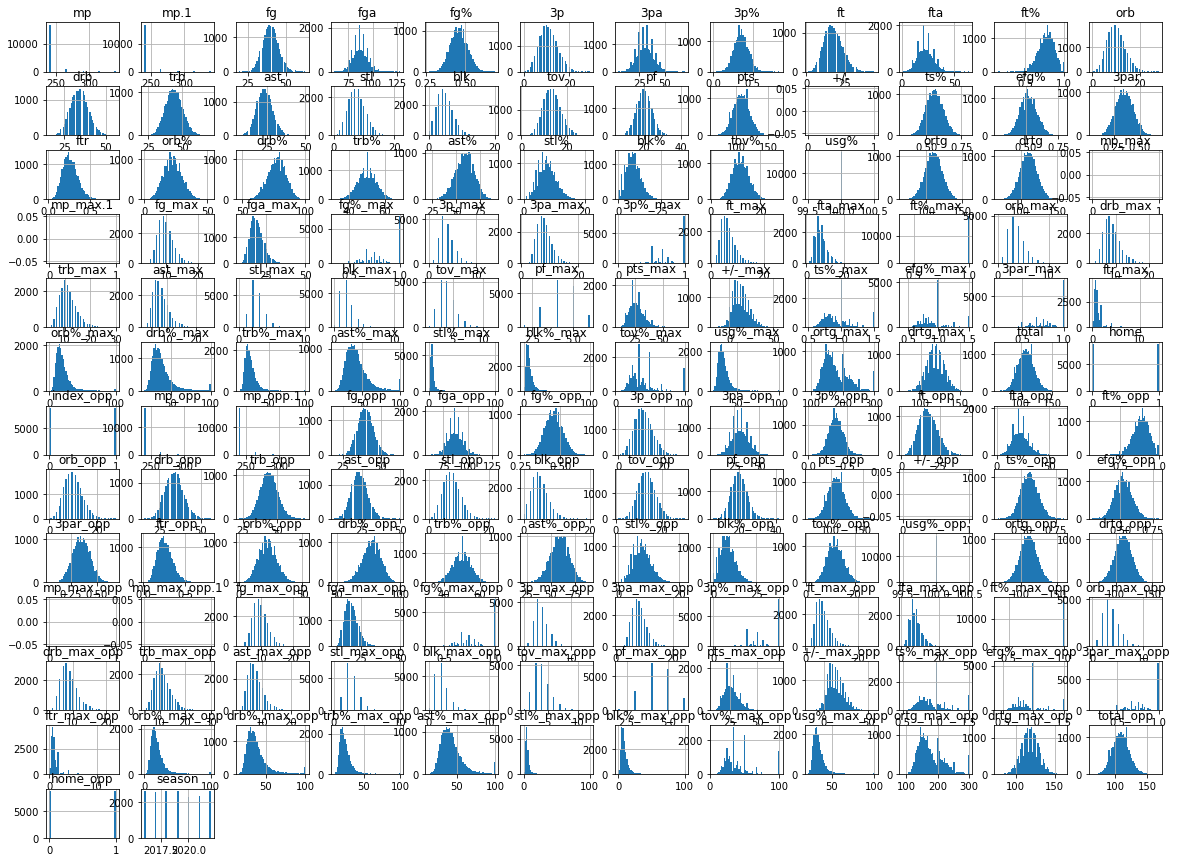

In [6]:
df_team_preprocess = pd.read_csv("nba_games.csv", index_col=0)
check_data_quality(df_team_preprocess) 

In [7]:
df_team_preprocess = df_team_preprocess.sort_values("date")
df_team_preprocess = df_team_preprocess.reset_index(drop=True)


df_team_preprocess = df_team_preprocess.drop(["mp.1", "mp_opp.1", "index_opp"], axis=1)


df_team_preprocess = make_last(df_team_preprocess)


won = df_team_preprocess['won']
del df_team_preprocess["won"]
won = won.map({True: 1, False: 0, np.nan: 2})
df_team_preprocess["won"] = won


nulls = pd.isnull(df_team_preprocess).sum()
nulls = nulls[nulls > 0]
valid_columns = df_team_preprocess.columns[~df_team_preprocess.columns.isin(nulls.index)]
df_team_preprocess = df_team_preprocess[valid_columns]

In [8]:
df_player_preprocess.head()

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,won,target,season,player,team,GAME_DATE,team_opp
175726,32.616667,7,14,0.500,2,5,0.400,2,2,1.0,5,7,12,6,2,5,1,1,2,4,18,-5,57.4,1,0,50.0,1,13060,13060,13060,5246,3047,3546,8149,3010,3567,6806,6376,7939,1,345,1966,772,1677,4192,30,2482,17509,11770,2656,3848,17379,370,1,118,629,0,1.0,2016-17,Draymond Green,GSW,2016-10-25,SAS
175674,36.600000,11,18,0.611,1,3,0.333,4,5,0.8,0,10,10,4,0,2,2,1,2,3,27,-13,57.0,1,0,50.0,1,13060,13060,13060,2123,508,1372,5011,6264,7843,7723,2830,3156,7710,12923,526,1517,3629,16648,1493,816,17509,11770,4543,1003,23187,389,1,118,629,0,1.0,2016-17,Kevin Durant,GSW,2016-10-25,SAS
175675,5.500000,1,2,0.500,1,1,1.000,2,2,1.0,0,0,0,0,0,0,0,0,1,1,5,1,5.0,0,0,6.0,1,1,1,1,24202,18863,21916,8149,6264,14538,1,6376,7939,1,12923,22443,23356,18531,16648,12237,7994,1,5176,12086,16895,11093,22723,2032,118,21660,1,1.0,2016-17,James Jones,CLE,2016-10-25,NYK
175676,16.100000,5,5,1.000,1,1,1.000,0,0,0.0,0,1,1,0,0,0,1,0,1,0,11,14,15.2,0,0,15.0,1,1,1,1,19020,6330,16180,1,6264,14538,1,13946,14843,13946,12923,17700,19668,18531,16648,12237,2482,1,5176,18615,9213,2444,15262,2032,118,14533,1,0.0,2016-17,Noah Vonleh,POR,2016-10-25,UTA
175677,11.133333,2,4,0.500,0,0,0.000,2,2,1.0,3,3,6,2,2,0,0,1,1,1,6,13,14.2,0,0,14.0,1,1,1,1,22160,15070,18194,8149,12221,18442,12221,6376,7939,1,1486,9449,5249,8113,4192,12237,7994,17509,5176,12086,15401,2758,16067,2032,118,15341,1,1.0,2016-17,David Lee,SAS,2016-10-25,GSW


In [9]:
df_team_preprocess.head()

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,total,home,mp_opp,fg_opp,fga_opp,fg%_opp,3p_opp,3pa_opp,3p%_opp,ft_opp,fta_opp,ft%_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,ts%_opp,efg%_opp,3par_opp,ftr_opp,orb%_opp,drb%_opp,trb%_opp,ast%_opp,stl%_opp,blk%_opp,tov%_opp,usg%_opp,ortg_opp,drtg_opp,fg_max_opp,fga_max_opp,fg%_max_opp,3p_max_opp,3pa_max_opp,3p%_max_opp,ft_max_opp,fta_max_opp,ft%_max_opp,orb_max_opp,drb_max_opp,trb_max_opp,ast_max_opp,stl_max_opp,blk_max_opp,tov_max_opp,pf_max_opp,pts_max_opp,+/-_max_opp,ts%_max_opp,efg%_max_opp,3par_max_opp,ftr_max_opp,orb%_max_opp,drb%_max_opp,trb%_max_opp,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,total_opp,home_opp,season,team,team_opp,date,won
0,240.0,35.0,83.0,0.422,6.0,18.0,0.333,19.0,27.0,0.704,8.0,25.0,33.0,21.0,9.0,3.0,18.0,26.0,95.0,0.501,0.458,0.217,0.325,18.6,54.3,37.1,60.0,9.0,4.5,15.9,100.0,94.9,110.9,7.0,20.0,1.000,2.0,7.0,0.667,10.0,15.0,1.0,3.0,5.0,6.0,9.0,3.0,3.0,5.0,5.0,18.0,5.0,1.000,1.000,1.000,0.750,19.8,26.3,13.6,43.4,5.3,6.3,37.5,38.9,201.0,120.0,95,0,240.0,41.0,96.0,0.427,9.0,30.0,0.300,20.0,22.0,0.909,21.0,35.0,56.0,29.0,8.0,7.0,20.0,29.0,111.0,0.525,0.474,0.313,0.229,45.7,81.4,62.9,70.7,8.0,10.8,15.9,100.0,110.9,94.9,14.0,26.0,1.000,5.0,12.0,1.000,7.0,7.0,1.0,5.0,5.0,9.0,7.0,2.0,2.0,7.0,5.0,40.0,20.0,1.136,1.000,0.462,0.571,39.0,27.2,25.2,50.1,19.1,7.9,69.4,43.7,206.0,104.0,111,1,2016,NOP,GSW,2015-10-27,0
1,240.0,38.0,94.0,0.404,9.0,29.0,0.310,10.0,17.0,0.588,11.0,39.0,50.0,26.0,5.0,7.0,10.0,21.0,95.0,0.468,0.452,0.309,0.181,21.6,84.8,51.5,68.4,5.0,10.3,9.0,100.0,95.5,97.5,12.0,22.0,0.571,3.0,7.0,0.500,3.0,4.0,1.0,4.0,10.0,12.0,7.0,1.0,2.0,3.0,4.0,25.0,9.0,0.714,0.714,1.000,2.000,10.8,41.9,23.8,31.2,2.8,18.5,30.4,29.0,138.0,105.0,95,0,240.0,37.0,87.0,0.425,7.0,19.0,0.368,16.0,23.0,0.696,7.0,40.0,47.0,13.0,6.0,10.0,13.0,22.0,97.0,0.499,0.466,0.218,0.264,15.2,78.4,48.5,35.1,6.0,15.4,11.8,100.0,97.5,95.5,8.0,22.0,0.750,3.0,5.0,0.750,5.0,5.0,1.0,2.0,8.0,10.0,5.0,2.0,6.0,4.0,6.0,19.0,9.0,0.820,0.875,0.556,1.333,12.2,38.5,26.0,30.3,2.8,14.0,53.2,34.6,162.0,104.0,97,1,2016,CLE,CHI,2015-10-27,0
2,240.0,37.0,87.0,0.425,7.0,19.0,0.368,16.0,23.0,0.696,7.0,40.0,47.0,13.0,6.0,10.0,13.0,22.0,97.0,0.499,0.466,0.218,0.264,15.2,78.4,48.5,35.1,6.0,15.4,11.8,100.0,97.5,95.5,8.0,22.0,0.750,3.0,5.0,0.750,5.0,5.0,1.0,2.0,8.0,10.0,5.0,2.0,6.0,4.0,6.0,19.0,9.0,0.820,0.875,0.556,1.333,12.2,38.5,26.0,30.3,2.8,14.0,53.2,34.6,162.0,104.0,97,1,240.0,38.0,94.0,0.404,9.0,29.0,0.310,10.0,17.0,0.588,11.0,39.0,50.0,26.0,5.0,7.0,10.0,21.0,95.0,0.468,0.452,0.309,0.181,21.6,84.8,51.5,68.4,5.0,10.3,9.0,100.0,95.5,97.5,12.0,22.0,0.571,3.0,7.0,0.500,3.0,4.0,1.0,4.0,10.0,12.0,7.0,1.0,2.0,3.0,4.0,25.0,9.0,0.714,0.714,1.000,2.000,10.8,41.9,23.8,31.2,2.8,18.5,30.4,29.0,138.0,105.0,95,0,2016,CHI,CLE,2015-10-27,1
3,240.0,41.0,96.0,0.427,9.0,30.0,0.300,20.0,22.0,0.909,21.0,35.0,56.0,29.0,8.0,7.0,20.0,29.0,111.0,0.525,0.474,0.313,0.229,45.7,81.4,62.9,70.7,8.0,10.8,15.9,100.0,110.9,94.9,14.0,26.0,1.000,5.0,12.0,1.000,7.0,7.0,1.0,5.0,5.0,9.0,7.0,2.0,2.0,7.0,5.0,40.0,20.0,1.136,1.000,0.462,0.571,39.0,27.2,25.2,50.1,19.1,7.9,69.4,43.7,206.0,104.0,111,1,240.0,35.0,83.0,0.422,6.0,18.0,0.333,19.0,27.0,0.704,8.0,25.0,33.0,21.0,9.0,3.0,18.0,26.0,95.0,0.501,0.458,0.217,0.325,18.6,54.3,37.1,60.0,9.0,4.5,15.9,100.0,94.9,110.9,7.0,20.0,1.000,2.0,7.0,0.667,10.0,15.0,1.0,3.0,5.0,6.0,9.0,3.0,3.0,5.0,5.0,18.0,5.0,1.000,1.000,1.000,0.750,19.8,26.3,13.6,43.4,5.3,6.3,37.5,38.9,201.0,120.0,95,0,2016,GSW,NOP,2015-10-27,1
4,240.0,37.0,82.0,0.451,8.0,27.0,0.296,12.0,15.0,0.800,7.0,33.0,40.

In [10]:
df_player = df_player_preprocess
df_team = df_team_preprocess

In [11]:
removed_columns_player = ['season', 'player', 'team', 'GAME_DATE','team_opp', 'won', 'target']
selected_columns_player = df_player.columns[~df_player.columns.isin(removed_columns_player)]

scaler = MinMaxScaler()
df_player[selected_columns_player] = scaler.fit_transform(df_player[selected_columns_player])

In [12]:
removed_columns_team = ["season", "date", "won", "target", "team", "team_opp"]
selected_columns_team = df_team.columns[~df_team.columns.isin(removed_columns_team)]

scaler = MinMaxScaler()
df_team[selected_columns_team] = scaler.fit_transform(df_team[selected_columns_team])

In [13]:
df_player.head()

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,won,target,season,player,team,GAME_DATE,team_opp
175726,0.542511,0.304348,0.318182,0.500,0.142857,0.208333,0.400,0.076923,0.068966,1.0,0.357143,0.304348,0.400000,0.24,0.166667,0.5,0.1,0.125,0.333333,0.210526,0.253521,0.451327,0.559447,1.0,0.0,0.505051,0.0,0.995351,0.734601,0.995351,0.200673,0.133252,0.141286,0.356446,0.211440,0.174223,0.478181,0.449545,0.527793,0.000000,0.025921,0.086882,0.032845,0.086839,0.238572,0.002360,0.299457,0.669829,0.454191,0.140313,0.164016,0.664856,0.014118,0.000000,0.823944,0.024783,0,1.0,2016-17,Draymond Green,GSW,2016-10-25,SAS
175674,0.608766,0.478261,0.409091,0.611,0.071429,0.125000,0.333,0.153846,0.172414,0.8,0.000000,0.434783,0.333333,0.16,0.000000,0.2,0.2,0.125,0.333333,0.157895,0.380282,0.380531,0.555760,1.0,0.0,0.505051,0.0,0.995351,0.734601,0.995351,0.081188,0.022179,0.054641,0.219170,0.440096,0.383135,0.542618,0.199492,0.209774,0.543615,0.973702,0.023213,0.064582,0.187979,0.947629,0.121439,0.098371,0.669829,0.454191,0.240038,0.042720,0.887061,0.014845,0.000000,0.823944,0.024783,0,1.0,2016-17,Kevin Durant,GSW,2016-10-25,SAS
175675,0.091481,0.043478,0.045455,0.500,0.071429,0.041667,1.000,0.076923,0.068966,1.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000,0.166667,0.052632,0.070423,0.504425,0.076498,0.0,0.0,0.060606,0.0,0.000000,0.000000,0.000000,0.925929,0.825145,0.873421,0.356446,0.440096,0.710231,0.000000,0.449545,0.527793,0.000000,0.973702,0.992262,0.994931,0.960104,0.947629,0.995930,0.964756,0.000000,0.199714,0.638675,0.720273,0.424363,0.869376,0.861323,0.823944,0.854736,1,1.0,2016-17,James Jones,CLE,2016-10-25,NYK
175676,0.267790,0.217391,0.113636,1.000,0.071429,0.041667,1.000,0.000000,0.000000,0.0,0.000000,0.043478,0.033333,0.00,0.000000,0.0,0.1,0.000,0.166667,0.000000,0.154930,0.619469,0.170507,0.0,0.0,0.151515,0.0,0.000000,0.000000,0.000000,0.727666,0.276871,0.644813,0.000000,0.440096,0.710231,0.000000,0.983358,0.986835,0.983358,0.973702,0.782553,0.837821,0.960104,0.947629,0.995930,0.299457,0.000000,0.199714,0.983723,0.392752,0.093465,0.583907,0.861323,0.823944,0.573481,1,0.0,2016-17,Noah Vonleh,POR,2016-10-25,UTA
175677,0.185180,0.086957,0.090909,0.500,0.000000,0.000000,0.000,0.076923,0.068966,1.0,0.214286,0.130435,0.200000,0.08,0.166667,0.0,0.0,0.125,0.166667,0.052632,0.084507,0.610619,0.161290,0.0,0.0,0.141414,0.0,0.000000,0.000000,0.000000,0.847802,0.659215,0.725081,0.356446,0.858689,0.900967,0.858689,0.449545,0.527793,0.000000,0.111898,0.417739,0.223566,0.420311,0.238572,0.995930,0.964756,0.669829,0.199714,0.638675,0.656576,0.105479,0.614708,0.861323,0.823944,0.605367,1,1.0,2016-17,David Lee,SAS,2016-10-25,GSW


In [14]:
df_team.head()

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,total,home,mp_opp,fg_opp,fga_opp,fg%_opp,3p_opp,3pa_opp,3p%_opp,ft_opp,fta_opp,ft%_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,ts%_opp,efg%_opp,3par_opp,ftr_opp,orb%_opp,drb%_opp,trb%_opp,ast%_opp,stl%_opp,blk%_opp,tov%_opp,usg%_opp,ortg_opp,drtg_opp,fg_max_opp,fga_max_opp,fg%_max_opp,3p_max_opp,3pa_max_opp,3p%_max_opp,ft_max_opp,fta_max_opp,ft%_max_opp,orb_max_opp,drb_max_opp,trb_max_opp,ast_max_opp,stl_max_opp,blk_max_opp,tov_max_opp,pf_max_opp,pts_max_opp,+/-_max_opp,ts%_max_opp,efg%_max_opp,3par_max_opp,ftr_max_opp,orb%_max_opp,drb%_max_opp,trb%_max_opp,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,total_opp,home_opp,season,team,team_opp,date,won
0,0.0,0.363636,0.338235,0.366029,0.206897,0.212121,0.395487,0.418605,0.412698,0.654609,0.285714,0.225,0.224490,0.325581,0.409091,0.15,0.586207,0.555556,0.298077,0.359081,0.337917,0.268750,0.394207,0.354286,0.129524,0.151351,0.555079,0.414747,0.116883,0.555970,0.0,0.293085,0.468716,0.190476,0.285714,1.000000,0.142857,0.260870,0.667,0.36,0.400000,1.0,0.230769,0.10,0.076923,0.304348,0.3,0.272727,0.363636,0.75,0.133333,0.306667,0.500,0.538319,1.0000,0.049020,0.198,0.117365,0.049505,0.350917,0.053,0.063,0.344864,0.215661,0.530806,0.505882,0.298077,0.0,0.0,0.500000,0.529412,0.377990,0.310345,0.393939,0.356295,0.441860,0.333333,0.893816,0.750000,0.475,0.693878,0.511628,0.363636,0.35,0.655172,0.638889,0.451923,0.409186,0.369352,0.418750,0.273300,0.870476,0.645714,0.848649,0.708155,0.368664,0.280519,0.555970,0.0,0.468716,0.293085,0.523810,0.428571,1.000000,0.357143,0.478261,1.000,0.24,0.171429,1.0,0.384615,0.10,0.192308,0.217391,0.2,0.181818,0.545455,0.75,0.500000,0.506667,0.636,0.538319,0.32750,0.036173,0.390,0.128144,0.177118,0.427752,0.191,0.079,0.679245,0.277279,0.554502,0.317647,0.451923,1.0,2016,NOP,GSW,2015-10-27,0
1,0.0,0.431818,0.500000,0.322967,0.310345,0.378788,0.368171,0.209302,0.253968,0.519253,0.392857,0.575,0.571429,0.441860,0.227273,0.35,0.310345,0.416667,0.298077,0.290188,0.326130,0.412500,0.212846,0.411429,0.710476,0.540541,0.675250,0.230415,0.267532,0.298507,0.0,0.299671,0.321625,0.428571,0.333333,0.340000,0.214286,0.260870,0.500,0.08,0.085714,1.0,0.307692,0.35,0.307692,0.217391,0.1,0.181818,0.181818,0.50,0.250000,0.360000,0.214,0.274238,1.0000,0.138735,0.108,0.304192,0.161716,0.211009,0.028,0.185,0.270440,0.088575,0.232227,0.329412,0.298077,0.0,0.0,0.409091,0.397059,0.373206,0.241379,0.227273,0.437055,0.348837,0.349206,0.645274,0.250000,0.600,0.510204,0.139535,0.272727,0.50,0.413793,0.444444,0.317308,0.354906,0.353635,0.270313,0.317380,0.289524,0.588571,0.459459,0.198856,0.276498,0.400000,0.402985,0.0,0.321625,0.299671,0.238095,0.333333,0.615385,0.214286,0.173913,0.750,0.16,0.114286,1.0,0.153846,0.25,0.230769,0.130435,0.2,0.545455,0.272727,1.00,0.150000,0.360000,0.320,0.422899,0.44500,0.090863,0.122,0.263473,0.185919,0.200688,0.028,0.140,0.509434,0.160462,0.345972,0.317647,0.317308,1.0,2016,CLE,CHI,2015-10-27,0
2,0.0,0.409091,0.397059,0.373206,0.241379,0.227273,0.437055,0.348837,0.349206,0.645274,0.250000,0.600,0.510204,0.139535,0.272727,0.50,0.413793,0.444444,0.317308,0.354906,0.353635,0.270313,0.317380,0.289524,0.588571,0.459459,0.198856,0.276498,0.400000,0.402985,0.0,0.321625,0.299671,0.238095,0.333333,0.615385,0.214286,0.173913,0.750,0.16,0.114286,1.0,0.153846,0.25,0.230769,0.130435,0.2,0.545455,0.272727,1.00,0.150000,0.360000,0.320,0.422899,0.4450,0.090863,0.122,0.263473,0.185919,0.200688,0.028,0.140,0.509434,0.160462,0.345972,0.317647,0.317308,1.0,0.0,0.431818,0.500000,0.322967,0.31034

In [15]:
df_player_rolling = df_player[list(selected_columns_player) + ["season","player", "won","team"]]
df_team_rolling = df_team[list(selected_columns_team) + ["won", "team", "season"]]

In [16]:
def find_team_averages(player):
    rolling = player.rolling(10).mean()
    return rolling

df_player_rolling = df_player_rolling.groupby(["player", "season"], group_keys=False).apply(find_team_averages)
df_team_rolling = df_team_rolling.groupby(["team", "season"], group_keys=False).apply(find_team_averages)

In [17]:
rolling_cols_player = [f"{col}_10" for col in df_player_rolling.columns]
df_player_rolling.columns = rolling_cols_player
df_player = pd.concat([df_player, df_player_rolling], axis=1)


rolling_cols_team = [f"{col}_10" for col in df_team_rolling.columns]
df_team_rolling.columns = rolling_cols_team
df_team = pd.concat([df_team, df_team_rolling], axis=1)

df_player = df_player.dropna()
df_team = df_team.dropna()

In [18]:
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col_player(df, col_name):
    return df.groupby("player", group_keys=False).apply(lambda x: shift_col(x, col_name))

def add_col_team(df, col_name):
    return df.groupby("team", group_keys=False).apply(lambda x: shift_col(x, col_name))

In [19]:
df_player["team_opp_next"] = add_col_player(df_player, "team_opp")
df_player["game_date_next"] = add_col_player(df_player, "GAME_DATE")

df_team["home_next"] = add_col_team(df_team, "home")
df_team["team_opp_next"] = add_col_team(df_team, "team_opp")
df_team["game_date_next"] = add_col_team(df_team, "date")

df_team = df_team.merge(df_team[rolling_cols_team + ["team_opp_next", "game_date_next", "team"]],
                left_on=["team", "game_date_next"],
                right_on=["team_opp_next", "game_date_next"])

df_team.rename(columns={'team_x': 'team'}, inplace=True)

In [20]:
full = pd.merge(df_player, df_team, left_on=['team', 'GAME_DATE'], right_on=['team', 'date'])
full = make_last(full)

In [21]:
full[full['player']=='LeBron James']

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,won_x,target,MIN_10,FGM_10,FGA_10,FG_PCT_10,FG3M_10,FG3A_10,FG3_PCT_10,FTM_10,FTA_10,FT_PCT_10,OREB_10,DREB_10,REB_10,AST_10,TOV_10,STL_10,BLK_10,BLKA_10,PF_10,PFD_10,PTS_10,PLUS_MINUS_10,NBA_FANTASY_PTS_10,DD2_10,TD3_10,WNBA_FANTASY_PTS_10,GP_RANK_10,W_RANK_10,L_RANK_10,W_PCT_RANK_10,MIN_RANK_10,FGM_RANK_10,FGA_RANK_10,FG_PCT_RANK_10,FG3M_RANK_10,FG3A_RANK_10,FG3_PCT_RANK_10,FTM_RANK_10,FTA_RANK_10,FT_PCT_RANK_10,OREB_RANK_10,DREB_RANK_10,REB_RANK_10,AST_RANK_10,TOV_RANK_10,STL_RANK_10,BLK_RANK_10,BLKA_RANK_10,PF_RANK_10,PFD_RANK_10,PTS_RANK_10,PLUS_MINUS_RANK_10,NBA_FANTASY_PTS_RANK_10,DD2_RANK_10,TD3_RANK_10,WNBA_FANTASY_PTS_RANK_10,won_10,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,total,home,mp_opp,fg_opp,fga_opp,fg%_opp,3p_opp,3pa_opp,3p%_opp,ft_opp,fta_opp,ft%_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,ts%_opp,efg%_opp,3par_opp,ftr_opp,orb%_opp,drb%_opp,trb%_opp,ast%_opp,stl%_opp,blk%_opp,tov%_opp,usg%_opp,ortg_opp,drtg_opp,fg_max_opp,fga_max_opp,fg%_max_opp,3p_max_opp,3pa_max_opp,3p%_max_opp,ft_max_opp,fta_max_opp,ft%_max_opp,orb_max_opp,drb_max_opp,trb_max_opp,ast_max_opp,stl_max_opp,blk_max_opp,tov_max_opp,pf_max_opp,pts_max_opp,+/-_max_opp,ts%_max_opp,efg%_max_opp,3par_max_opp,ftr_max_opp,orb%_max_opp,drb%_max_opp,trb%_max_opp,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,total_opp,home_opp,season_y,won_y,mp_10_x,fg_10_x,fga_10_x,fg%_10_x,3p_10_x,3pa_10_x,3p%_10_x,ft_10_x,fta_10_x,ft%_10_x,orb_10_x,drb_10_x,trb_10_x,ast_10_x,stl_10_x,blk_10_x,tov_10_x,pf_10_x,pts_10_x,ts%_10_x,efg%_10_x,3par_10_x,ftr_10_x,orb%_10_x,drb%_10_x,trb%_10_x,ast%_10_x,stl%_10_x,blk%_10_x,tov%_10_x,usg%_10_x,ortg_10_x,drtg_10_x,fg_max_10_x,fga_max_10_x,fg%_max_10_x,3p_max_10_x,3pa_max_10_x,3p%_max_10_x,ft_max_10_x,fta_max_10_x,ft%_max_10_x,orb_max_10_x,drb_max_10_x,trb_max_10_x,ast_max_10_x,stl_max_10_x,blk_max_10_x,tov_max_10_x,pf_max_10_x,pts_max_10_x,+/-_max_10_x,ts%_max_10_x,efg%_max_10_x,3par_max_10_x,ftr_max_10_x,orb%_max_10_x,drb%_max_10_x,trb%_max_10_x,ast%_max_10_x,stl%_max_10_x,blk%_max_10_x,tov%_max_10_x,usg%_max_10_x,ortg_max_10_x,drtg_max_10_x,total_10_x,home_10_x,mp_opp_10_x,fg_opp_10_x,fga_opp_10_x,fg%_opp_10_x,3p_opp_10_x,3pa_opp_10_x,3p%_opp_10_x,ft_opp_10_x,fta_opp_10_x,ft%_opp_10_x,orb_opp_10_x,drb_opp_10_x,trb_opp_10_x,ast_opp_10_x,stl_opp_10_x,blk_opp_10_x,tov_opp_10_x,pf_opp_10_x,pts_opp_10_x,ts%_opp_10_x,efg%_opp_10_x,3par_opp_10_x,ftr_opp_10_x,orb%_opp_10_x,drb%_opp_10_x,trb%_opp_10_x,ast%_opp_10_x,stl%_opp_10_x,blk%_opp_10_x,tov%_opp_10_x,usg%_opp_10_x,ortg_opp_10_x,drtg_opp_10_x,fg_max_opp_10_x,fga_max_opp_10_x,fg%_max_opp_10_x,3p_max_opp_10_x,3pa_max_opp_10_x,3p%_max_opp_10_x,ft_max_opp_10_x,fta_max_opp_10_x,ft%_max_opp_10_x,orb_max_opp_10_x,drb_max_opp_10_x,trb_max_opp_10_x,ast_max_opp_10_x,stl_max_opp_10_x,blk_max_opp_10_x,tov_max_opp_10_x,pf_max_opp_10_x,pts_max_opp_10_x,+/-_max_opp_10_x,ts%_max_opp_10_x,efg%_max_opp_10_x,3par_max_opp_10_x,ftr_max_opp_10_x,orb%_max_opp_10_x,drb%_max_opp_10_x,trb%_max_opp_10_x,ast%_max_opp_10_x,stl%_max_opp_10_x,blk%_max_opp_10_x,tov%_max_opp_10_x,usg%_max_opp_10_x,ortg_max_opp_10_x,drtg_

# K-Means

In [22]:
removed_cols = (list(full.columns[full.dtypes == "object"]) + ['target'])
selected_cols = full.columns[~full.columns.isin(removed_cols)]

kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(full[selected_cols])
pd.DataFrame(kmeans.cluster_centers_, columns=selected_cols).T

,0,1,2,3,4
MIN,0.389453,0.396521,0.390989,0.392123,0.389006
FGM,0.175339,0.167764,0.159340,0.175442,0.182327
FGA,0.188743,0.199265,0.190532,0.197954,0.194401
FG_PCT,0.456361,0.417047,0.412056,0.437741,0.456899
FG3M,0.076662,0.081271,0.063724,0.082859,0.094729
...,...,...,...,...,...
drtg_max_opp_10_y,0.477721,0.521217,0.480963,0.497370,0.517987
total_opp_10_y,0.404925,0.453389,0.405586,0.454455,0.456028
home_opp_10_y,0.501665,0.497600,0.498998,0.501467,0.502923
won_10_y,0.497857,0.507189,0.500884,0.501887,0.494688


In [23]:
full['grade'] = kmeans.labels_
full['grade'].value_counts()

3    35657
0    20486
2    18662
1    17874
4    17621
Name: grade, dtype: int64

In [24]:
full[full['team'] == 'GSW']['grade'].value_counts()

0    1268
3    1249
4     812
1     586
2     377
Name: grade, dtype: int64

In [25]:
full[full['team'] == 'LAL']['grade'].value_counts()

3    1365
2     937
1     706
4     590
0     504
Name: grade, dtype: int64

In [26]:
def add_target2(group):
    group["target"] = group["grade"].shift(-1)
    return group


full = full.groupby("player", group_keys=False).apply(add_target2)
full.dropna(inplace=True)
full = make_last(full)

In [27]:
temp = full[full['player'] == 'LeBron James']
temp[['player', 'date', 'team', 'grade', 'target']].head(30)

,player,date,team,grade,target
266,LeBron James,2016-11-15,CLE,0,0.0
609,LeBron James,2016-11-18,CLE,0,0.0
1323,LeBron James,2016-11-23,CLE,0,0.0
1382,LeBron James,2016-11-25,CLE,0,0.0
1779,LeBron James,2016-11-27,CLE,0,2.0
2003,LeBron James,2016-11-29,CLE,2,2.0
2199,LeBron James,2016-12-01,CLE,2,2.0
2270,LeBron James,2016-12-02,CLE,2,0.0
2731,LeBron James,2016-12-05,CLE,0,0.0
3025,LeBron James,2016-12-07,CLE,0,0.0


In [28]:
string_columns = full.select_dtypes(include='object').columns

# Drop string columns from the DataFrame
df_numeric = full.drop(string_columns, axis=1)

# Extract the input features X by excluding the 'grade' column
X = df_numeric.drop('target', axis=1)

# Extract the target variable y
y = df_numeric['target']

# Create an instance of the LinearRegression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Predict using the trained model
y_pred = model.predict(X)

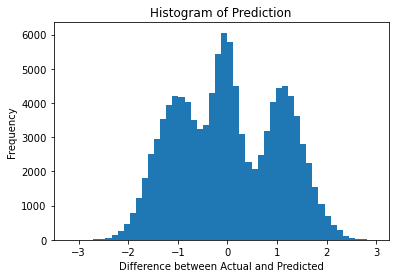

In [34]:
results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred})

results_df['diff'] = results_df['Predicted'] - results_df['Actual']


plt.hist(results_df['diff'], bins=50)
plt.xlabel('Difference between Actual and Predicted')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction')
plt.show()

In [30]:
results_df.describe()

,Actual,Predicted,diff
count,109430.000000,109430.000000,109430.000000
mean,2.112794,2.138268,0.025474
std,1.361514,0.895488,1.028396
min,0.000000,-0.212250,-3.196625
25%,1.000000,1.214109,-0.827080
50%,2.000000,2.439243,-0.030041
75%,3.000000,2.889587,0.941305
max,4.000000,4.190285,2.943573
